<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Class 3: Deep Q Networks</div>

1. <a href="#everything">Everything you need to know</a>
2. <a href="#reminder">Reminder</a>
3. <a href="#envs">Environments</a>
    1. <a href="#cartpole">Cartpole</a>
    2. <a href="#swingup">Cartpole swing-up</a>
    3. <a href="#pong">Pong</a>
3. <a href="#value-iteration">Value Iteration as a sequence of Supervized Learning problems</a>
4. <a href="#experience-replay">Experience Replay</a>
5. <a href="#dqn">A deep Q-network</a>
6. <a href="#tricks">Making DQN more efficient</a>
    1. <a href="#optimizer">Changing the optimizer</a>
    2. <a href="#nb-grad-steps">Several gradient steps</a>
    3. <a href="#target-networks">Target network</a>
    4. <a href="#error-clipping">Error clipping</a>
7. <a href="#metrics">Metrics</a>
8. <a href="#dqn-image">DQN on image-based tasks</a>
9. <a href="#further">Going further</a>
10. <a href="#challenge">Challenge</a>
    1. <a href="#bicycle">Bicycle</a>
    2. <a href="#sti">Structured Treatment Interruptions</a>
    3. <a href="#turn">Your turn to play</a>

In the previous classes we saw that one could replace the model-based value iteration process by an approximate value iteration one. When the approximation is done by performing stochastic approximation, we obtain the $Q$ learning algorithm. We saw it was straightforward to extend this to use experience replay memories and batch stochastic gradient descent. In this class, we combine the stochastic gradient descent approach with replay memories and represent $Q$ as a neural network. This yields the Deep Q-Networks algorithm.

There are few new concepts in this class compared to previous ones. Mainly, what we do is bring neural networks into the framework we have previously built. Therefore, this class is aimed at more practice. For this purpose, we start by introducing a set of [environments](#sec1) to illustrate further developments. Then we will start from Value Iteration and repeat the thought process of the previous classes, introduce [stochastic gradient descent](#sec2), [experience replay](#sec3) and reach the [DQN algorithm](#sec4). The end of the class is an [open challenge](#challenge) on several difficult benchmarks.

<div class="alert alert-warning">

**Prerequisites:**
- Stochastic Approximation for Approximate Value Iteration
- Deep Learning
<div>

Let's start with this quote:

> The idea that we learn by interacting with our environment is probably the first to occur to us when we think about the nature of learning. When an infant plays, waves its arms, or looks about, it has no explicit teacher, but it does have a direct sensorimotor connection to its environment. Exercising this connection produces a wealth of information about cause and effect, about the consequences of actions, and about what to do in order to achieve goals. Throughout our lives, such interactions are undoubtedly a major source of knowledge about our environment and ourselves. Whether we are learning to drive a car or to hold a conversation, we are acutely aware of how our environment responds to what we do, and we seek to influence what happens through our behavior. Learning from interaction is a foundational idea underlying nearly all theories of learning and intelligence. (Richard S. Sutton)

# <div id="everything"></div>Everything you need to know

Everything you should remember after this session.<br>
<br>
<div class="alert alert-success">

- Deep Q-Networks is an approximate value iteration algorithm that uses experience replay and stochastic gradient descent to learn $Q^*$ as a neural network. The DQN itself is the neural network.
- DQN pseudo-code
```
         state = init()
         loop:
            action = greedy_action(DQN) or random_action()
            new_state, reward = step(state, action)
            replay_memory.add(state, action, reward, new_state)
            minibatch = replay_memory.sample(minibatch_size)
            X_train = Y_train = []
            for (s, a, r, s') in minibatch:
                Q  = DQN.predict(s)
                Q' = DQN.predict(s')
                if non-terminal(s'): 
                    update = r + gamma * max(Q')    
                else:  
                    update = r
                Q[a] = update
                X_train.add(s)
                Y_train.add(Q)
            DQN.train_one_step(X_train, Y_train)
            state = new_state
```
- The pseudo-code above can be improved by introducing a second network $Q^-$ called *target network*, that is used to compute `update` in the pseudo-code above. Every $C$ steps $Q^-$ is replaced by the learned network.
- Common improvements to DQN involve using a Huber loss and tuning the optimizer.
</div>

# <div id="reminder"></div>Reminder

- Value Iteration builds the sequence $Q_{n+1} = T^* Q_n$ that converges to $Q^*$
- Given a set of samples $\{(s,a,r,s')\}$, one can perform stochastic gradient descent on the loss $L_n(Q) = \|Q - T^* Q_n \|_2$ and thus approximate the sequence of value functions from value iteration.

# <div id="envs"></div>Environments

In this session, we will work with three different environments:
- CartPole
- A modified version of CartPole
- Pong

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## <div id="cartpole"></div>CartPole

In [2]:
import gymnasium as gym
cartpole = gym.make('CartPole-v1', render_mode='human')

From the [Gymnasium website](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 12 degrees from vertical, or the cart moves more than 2.4 units from the center.

Beware that, as most Gym environments, CartPole has a maximum number of steps before necessarily returning `done=True`.

In [3]:
cartpole._max_episode_steps

500

The cartpole is represented by a state $s = (x, \dot{x}, \theta, \dot{\theta})$ with :
  - $x$ the position of the cartpole along the x-axis
  - $\theta$ the angle of the pole

In [4]:
print(cartpole.action_space)
print(cartpole.observation_space)
print(cartpole.env.metadata)

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
{'render_modes': ['human', 'rgb_array'], 'render_fps': 50}


In [5]:
import time
import numpy as np

_ = cartpole.reset()
cartpole.render()
for i in range(10000):
    _, _, d, _, _ = cartpole.step(np.random.randint(2))
    cartpole.render()
    if d:
        print("Final nb steps:", i)
        break
    time.sleep(cartpole.unwrapped.tau) # not actually real-time, just for readability

/home/tom_duq/anaconda3/envs/myenv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Final nb steps: 23


In [6]:
cartpole.close()

## <div id="swingup"></div>CartPole Swing-up

The idea here is to keep the same environment, but instead of learning how to stabilize it around the unstable equilibrium point, we'd like to learn to swing it up. Here are the changes:
- `reset` now puts the pole pointing down. The initial state is $(0,0,\pi,0)$ plus a vector of four uniformly random values in [-0.05,0.05].
- `step` now returns `done=True` when the cart leaves the $x\in [-2.4,2.4]$ interval or when the pole swings faster than $4\pi$ radians per second.
- the reward is still +1 for keeping the pole within 12 degrees of the vertical, it is 0 for all other time steps and -10 for swinging too fast or exiting the screen.

In [7]:
from environments.swingup import CartPoleSwingUp
swingup = CartPoleSwingUp(render_mode="human")

In [8]:
import numpy as np

x = swingup.reset()
swingup.render()

for i in range(1000):
    _, _, d, _, _ = swingup.step(np.random.randint(2))
    swingup.render()
    if d:
        print("Final nb steps:", i)
        break
    time.sleep(cartpole.unwrapped.tau)

Final nb steps: 84


In [9]:
swingup.close()

## <div id="pong"></div>Pong

Let's build an agent that learns to play Pong, one of the [Atari games](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py) in Gym (originally in the [Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)). You might want to try different games later on (like the popular Breakout game for instance).

In [10]:
import gymnasium as gym
%pip install ale-py
import ale_py

gym.register_envs(ale_py)
pong = gym.make('ALE/Pong-v5')

Note: you may need to restart the kernel to use updated packages.


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Here is the environment's description.
> Maximize your score in the Atari 2600 game Pong. In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). Each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from $\{2, 3, 4\}$.

In [11]:
import numpy as np
print(pong.observation_space)
print(pong.observation_space.shape)
print(np.min(pong.observation_space.low))
print(np.max(pong.observation_space.high))
print(pong.action_space)
#help(env.observation_space)

Box(0, 255, (210, 160, 3), uint8)
(210, 160, 3)
0
255
Discrete(6)


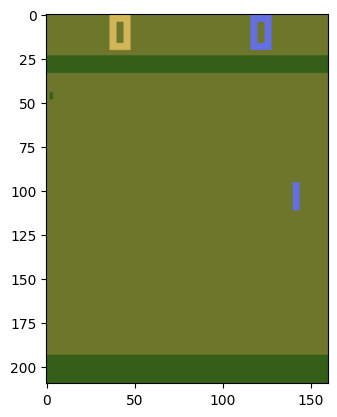

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
s, _ = pong.reset()
plt.imshow(s)
plt.show()

<div class="alert alert-warning">

**Exercise:** What is the number of possible states? Why is this not an MDP? What would one need to turn this back into an MDP?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Of course, most of the possible images will never occur in a Breakout game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be contradictory of our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data.

This is not an MDP because the transition dynamics do not respect Markov's property. The probability of transitioning from $s_t$ to $s_{t+1}$ is *not* independent of previous states. The problem here is that a single frame of the game does not reflect the velocity of the ball.

To recover Markov's property one could simply stack a few frames together in the state space.
</details>

There are 18 buttons on the Atari controller. However not all games use all buttons. Our interface to Pong specifies 6 possible actions:
- 0 NOOP (no operation)
- 1 FIRE (press fire button, doesn't do anything in Pong)
- 2 RIGHT (actually moves the paddle up in Pong)
- 3 LEFT (actually moves the paddle down in Pong)
- 4 UP (moves the paddle upwards)
- 5 DOWN (moves the paddle downwards)

The available actions in Pong go up to the 6th action for naming consistency (UP and DOWN), but the four first actions are not really useful.

Also, for an unknown reason, the game does not start until the 20th frame (but always starts automatically, pressing FIRE does not change anything).

The frame rate is 60Hz.

To avoid confusion between the 6 actions allowed by Gym, let's build a wrapper around our environment, with only 2 possible actions ("0" for UP and "1" for DOWN) and a downscaled observation space. Unless you're curious and want to dig in the code, you can simply run the following cells and just use the resulting environment.

In [13]:
from environments.pongwrapper import PongWrapper

In [14]:
pong = PongWrapper(
    render_mode="human",
    noop_max=0,
    frame_skip=4,
    terminal_on_life_loss=True,
    grayscale_obs=True,
    scale_obs=True,
)

ALSA lib .././../src/v1.2.13-3eeec0cd85.clean/src/conf.c:4580:(snd_config_update_r) Cannot access file /usr/share/alsa/alsa.conf
ALSA lib .././../src/v1.2.13-3eeec0cd85.clean/src/conf.c:4580:(snd_config_update_r) Cannot access file /usr/share/alsa/alsa.conf
ALSA lib ../.././../src/v1.2.13-3eeec0cd85.clean/src/pcm/pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default


ALSA lib .././../src/v1.2.13-3eeec0cd85.clean/src/conf.c:4580:(snd_config_update_r) Cannot access file /usr/share/alsa/alsa.conf


shape: (84, 84), min = 0.34117648, max = 0.91764706, dtype = float32


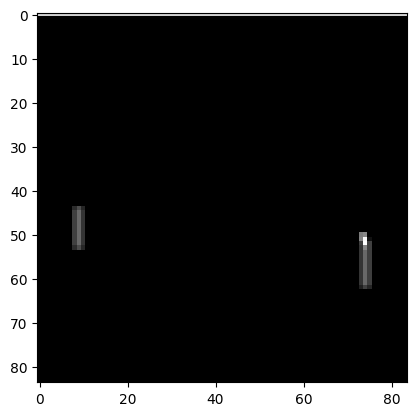

In [15]:
# Trying a random agent in Pong
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

pong.reset()
for i in range(60):
    a = np.random.randint(2)
    s, r, _, _, _ = pong.step(a)
    time.sleep(1 / 60)
    
pong.close()
print("shape: ", s.shape, ", min = ", s.min(), ", max = ", s.max(), ", dtype = ", s.dtype, sep='')
plt.imshow(s, cmap='gray');

In [16]:
pong = PongWrapper(
    noop_max=0,
    frame_skip=4,
    terminal_on_life_loss=True,
    grayscale_obs=True,
    scale_obs=True,
)

ALSA lib .././../src/v1.2.13-3eeec0cd85.clean/src/conf.c:4580:(snd_config_update_r) Cannot access file /usr/share/alsa/alsa.conf


# <div id="value-iteration"></div>Value Iteration as a sequence of Supervized Learning problems

Recall the Value Iteration update: $Q_{n+1} = T^*Q_n$.

<div class="alert alert-warning">

**Exercise:**  
Suppose $Q_{n+1}$ is a parametric function $Q(s,a;\theta_{n+1})$ with parameters $\theta_{n+1}$. We want to approximate $T^*Q_n$ with $Q(s,a;\theta_{n+1})$. Write the loss function minimized for this regression problem.
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Let's start over from the beginning. We want to find:
$$\pi^*(s) = \arg\max_{\pi} \mathbb{E}_{\left(r_t\right)_{t\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r_t \ \Big| \ s, \pi \right], \ \forall s\in S.$$

We have seen this was equivalent to finding the optimal value function $Q^*$:
$$Q^*(s,a) = \max_{\pi} \mathbb{E}_{\left(r_t\right)_{t\in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r_t \ \Big| \  s,a, \pi \right], \ \forall (s,a) \in S\times A.$$

And we have established that $Q^*$ was the only solution to Bellman's optimality equation:
$$Q(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a')\right].$$

By writing $T^*$ Bellman's optimality operator, we have, by definition:
$$(T^*Q)(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a')\right].$$

And thus, $Q^*$ is the only solution to $Q=T^*Q$.

It appears $T^*$ is a contraction mapping on the $\mathcal{F}(S\times A,\mathbb{R})$ space. Value Iteration exploits this property to build the sequence $Q_{n+1} = T^*Q_n$ which converges to $Q^*$.

Let's now suppose that $Q_n$ is a function approximator, whose parameters are $\theta_n$. We shall write $Q_n(s,a) = Q(s,a;\theta_n)$. Then building $\theta_{n+1}$ knowing $\theta_n$ is the regression problem that minimizes the loss:
\begin{gather}
L_n(\theta) = \left\| y_n(s,a) - Q(s,a;\theta) \right\|,\\
\textrm{with } y_n(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a';\theta_{n})\right].
\end{gather}

If this loss can be optimized and goes to zero, then we have found the true $Q_{n+1}$. If not, then we have found an approximation of it in the norm used to define $L_n$.

</details>

<div class="alert alert-warning">

**Exercise:**  
Use the L2 norm in the loss of the regression problem above, then write the gradient of the loss with respect to the regressor's parameters. Use this to introduce a stochastic gradient descent method to find $\theta_{n+1}$.
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Our loss becomes:
\begin{gather}
L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \big( y_n(s,a) - Q(s,a;\theta) \big)^2 \right],\\
\textrm{with } y_n(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a';\theta_{n})\right].
\end{gather}

In the expression above, $\rho$ is a distribution over the state-action space. Often, it is considered to be the behavior distribution, that is the distribution of samples under the current behavior policy, like $\epsilon$-greedy. Note that this choice is debatable.

So the gradient of this loss is:
\begin{gather}
\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \big( y_n(s,a) - Q(s,a;\theta) \big) \nabla_\theta Q(s,a;\theta) \right]\\
\textrm{with } y_n(s,a) = \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a';\theta_{n})\right].
\end{gather}

And when we wrap all this together:
$$\nabla_\theta L_n(\theta) = \mathbb{E}_{(s,a) \sim \rho(\cdot)}\left[ \left( \mathbb{E}_{s' \sim p(\cdot|s,a)} \left[r(s,a,s') + \gamma \max_{a'} Q(s',a';\theta_{n})\right] - Q(s,a;\theta) \right) \nabla_\theta Q(s,a;\theta) \right]$$

$$\nabla_\theta L_n(\theta) = \mathbb{E}_{\substack{(s,a) \sim \rho(\cdot)\\ s' \sim p(\cdot|s,a)}}\left[ \left( r(s,a,s') + \gamma \max_{a'} Q(s',a';\theta_{n}) - Q(s,a;\theta) \right) \nabla_\theta Q(s,a;\theta) \right]$$

We can build a Monte Carlo estimate of this gradient, given a mini-batch of independently and identically drawn samples $\left\{\left(s_i,a_i,r_i,s'_i\right)\right\}_{i\in [1,B]}$, with $(s,a) \sim \rho(\cdot)$ and $s' \sim p(\cdot | s,a)$:
$$\nabla_\theta L_n(\theta) \approx d_n(\theta) = \sum_{i=1}^B \left[ \left( r_i + \gamma \max_{a'} Q(s_i',a';\theta_{n}) - Q(s_i,a_i;\theta) \right) \nabla_\theta Q(s_i,a_i;\theta) \right].$$

The stochastic gradient descent procedure builds a sequence of parameter values $\theta_k$ such that:
$$\theta_{k+1} \leftarrow \theta_{k} - \alpha d_n(\theta_{k})$$

By repeating such gradient steps, one progressively minimizes $L_n(\theta)$ and finds $\theta_{n+1}$.

</details>

**Important remark:**  

In the update above, if the mini-batch contains a single element, the 1-sample update is precisely that of Q-learning! Then, in Q-learning, the new loss $L_{n+1}$ is defined and the process is repeated. Consequently, there is a new loss function at each time step.

<div class="alert alert-warning">

**Exercise:** can you spot the (subtle but essential) difference with Q-learning?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

Recall Q-learning. The update was indeed the same, except that at any time step the mini-batch's single element was not sampled independently from the previous minibatch! Indeed, $s'$ from the previous time step becomes $s$ for the current time step. So the successive mini-batches' elements are not drawn iid.

That's a key difference that questions the foundation of Q-learning in itself.
</details>

# <div id="experience-replay"></div>Experience Replay

To recover the independence assumption between samples, we can introduce the mechanism of [*Experience Replay*](http://www.incompleteideas.net/lin-92.pdf) by storing past samples into a *Replay Memory*. When samples are required for a mini-batch gradient update, they are collected uniformly from the replay memory, thus mimicking an (almost) independent draw according to $\rho(\cdot)$.

<div class="alert alert-warning">
    
**Exercise:**  
Design a class for the replay memory of the cart-pole example(s). Limit the size of this memory (via a FIFO mechanism) to $10^6$ samples (adapt this number to your computer's RAM). Test it by running a random policy for $2\cdot 10^6$ time steps.
</div>

In [19]:
# %load solutions/RL5_exercise1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

# Replay buffer class
import random


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.data, batch_size)

    def __len__(self):
        return len(self.data)


In [20]:
cartpole = gym.make("CartPole-v1")

# Testing insertion in the ReplayBuffer class
replay_buffer_size = int(1e6)
nb_samples = int(2e6)

memory = ReplayBuffer(replay_buffer_size)
state, _ = cartpole.reset()
for _ in trange(nb_samples):
    action = cartpole.action_space.sample()
    next_state, reward, done, _, _ = cartpole.step(action)
    memory.append(state, action, reward, next_state, done)
    if done:
        state, _ = cartpole.reset()
    else:
        state = next_state

print(len(memory))

# Testing sampling in the ReplayBuffer class
nb_batches = int(1e4)
batch_size = 50

for _ in trange(nb_batches):
    batch = memory.sample(batch_size)

print(memory.sample(2))

100%|██████████| 2000000/2000000 [01:21<00:00, 24409.57it/s]


1000000


100%|██████████| 10000/10000 [00:00<00:00, 1187582.54it/s]

None


<div class="alert alert-warning">
    
**Know your data structures!**

Taking the time to think about what makes a good replay buffer may save you hours of puzzled head-banging. It is important to know what you expect from your replay buffer to choose the right data structure.

Common mistake: we need a fixed sized memory, that works like a FIFO structure, so let's pick a deque. That sounds fair, deques (in Python) have a fixed maximum size and constant time insertion at the beginning and the end. BUT they also have $O(n)$ access time which means that for large replay buffers, sampling a minibatch may take forever.

Here, what we really need is a fixed-size FIFO, with $O(1)$ insertion at the end and $O(1)$ access.

This should motivate the choices made in the replay buffer class above.
</div>

# <div id="dqn"></div>A deep Q-network

The term Deep Q-Network was coined by the (now historical) paper **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)** by Mnih et al. (2013) that put forward the main ideas we develop here. All those were later popularized by DeepMind's paper in Nature **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** by Mnih et al. (2015).

Let's design a (deep) neural network that will serve as a function approximator for $Q(s,a;\theta)$. 

<center><img src="img/dqlas.png" height="15%" width="15%"></img></center>

Note that since we're going to have to compute $\max_a Q(s,a)$ it is preferable to avoid running as many passes through the network as there are actions. Therefore, instead of the network structure above, we will prefer to use the one below.

<center><img src="img/dqls.png" height="30%" width="30%"></img></center>

<div class="alert alert-warning">
    
**Exercise:**  
Declare a neural network for our $Q$ function. For the CartPole task, you can use a simple network with 2 hidden layers and 24 neurons on each layer. For the SwingUp task, go up to 50 neurons per layer. For Pong and the other environments... well wait a minute, we'll get to it later.
</div>

In [24]:
# %load solutions/RL5_exercise2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n
nb_neurons = 24

DQN = torch.nn.Sequential(
    nn.Linear(state_dim, nb_neurons),
    nn.ReLU(),
    nn.Linear(nb_neurons, nb_neurons),
    nn.ReLU(),
    nn.Linear(nb_neurons, n_action),
).to(device)


We're almost there. Now you can implement the algorithm that:
- takes $\epsilon$-greedy actions with respect to $Q$
- stores samples in the replay buffer
- at each interaction step with the environment, draws a mini-batch, computes the target values for each $(s,a)$ and takes a gradient step.
- repeats

<div class="alert alert-warning">
    
**Exercise:**  
Write this algorithm's pseudo-code, then proceed with your implementation, using the network and replay buffer you defined in the previous cells.
</div>

You can take inspiration from the algorithm on page 5 of **[Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)**.

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

         state = init()
         loop:
            action = greedy_action(DQN) or random_action()
            new_state, reward = step(state, action)
            replay_memory.add(state, action, reward, new_state)
            minibatch = replay_memory.sample(minibatch_size)
            X_train = Y_train = []
            for (s, a, r, s') in minibatch:
                Q  = DQN.predict(s)
                Q' = DQN.predict(s')
                if non-terminal(s'): 
                    update = r + gamma * max(Q')    
                else:  
                    update = r
                Q[a] = update
                X_train.add(s)
                Y_train.add(Q)
            DQN.train_one_step(X_train, Y_train)
            state = new_state
</details>

Now we can proceed with the implementation. This series of exercises break it down into small steps.

<div class="alert alert-warning">
    
**Exercise:**  
It will actually be useful to have separate torch.Tensor for each element type in the sampled minibatch.  
That is, one Tensor for a minibatch of states, another for actions, etc.
Let's redefine the sample function of our replay buffer class to that end.
</div>

In [40]:
# %load solutions/RL5_exercise3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import numpy as np
import random
import torch

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        X, A, R, Y, D = zip(*batch)
    
        # 2. Convert to tensors and return as a tuple for unpacking
        # Use a generic device check or pass device to the class
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        return (
            torch.FloatTensor(np.array(X)).to(device),
            torch.FloatTensor(np.array(A)).to(device),
            torch.FloatTensor(np.array(R)).to(device),
            torch.FloatTensor(np.array(Y)).to(device),
            torch.FloatTensor(np.array(D)).to(device)
        )
    def __len__(self):
        return len(self.data)


<div class="alert alert-warning">
    
**Exercise:**  
Define a utility function that computes the greedy action from a DQN and a batch of states.
</div>

In [41]:
# %load solutions/RL5_exercise4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import torch

def greedy_action(network, state):
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()


<div class="alert alert-warning">
    
**Exercise:**  
Write a class that keeps a replay buffer as internal attribute and implements the pseudo-code you wrote earlier.  
Here are a few tips:
- To ensure exploration, take a constant $\epsilon_{max}$ value during $\tau_{delay}$ time steps, then substract $\epsilon_{step}$ from $\epsilon$ at every time step until you reach time $\tau_{period}$.
- A common optimizer (instead of plain SGD) is RMSprop.
- Assume the interaction with the environment will be episodic. After each training episode store the episode's cumulated return for monitoring.

Write your class but don't run this code just yet!
</div>

In [42]:
# %load solutions/RL5_exercise5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import numpy as np
import torch

class DQNAgent:
    def __init__(self, config, model):
        self.gamma = config["gamma"]
        self.batch_size = config["batch_size"]
        self.nb_actions = config["nb_actions"]
        self.memory = ReplayBuffer(config["buffer_size"])
        self.epsilon_max = config["epsilon_max"]
        self.epsilon_min = config["epsilon_min"]
        self.epsilon_stop = config["epsilon_decay_period"]
        self.epsilon_delay = config["epsilon_delay_decay"]
        self.epsilon_step = (self.epsilon_max - self.epsilon_min) / self.epsilon_stop
        self.total_steps = 0
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(
            self.model.parameters(), lr=config["learning_rate"],
        )

    def gradient_step(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample from memory
        X, A, R, Y, D = self.memory.sample(self.batch_size)

        # Compute y_t = r(s, a) + \gamma * max_a' Q(s', a')
        QYmax = self.model(Y).max(1)[0].detach()
        update = torch.addcmul(R, 1 - D, QYmax, value=self.gamma)

        # Compute loss
        QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
        loss = self.criterion(QXA, update.unsqueeze(1))

        # Gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0

        while episode < max_episode:
            # Update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon - self.epsilon_step)

            # Select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = greedy_action(self.model, state)

            # Step and store in memory
            next_state, reward, done, _, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # Train
            self.gradient_step()

            # Next transition
            step += 1
            if done:
                episode += 1
                print(
                    f"Episode {episode:3d}, epsilon {epsilon:6.2f},",
                    f"batch size {len(self.memory):5d},",
                    f"episode return {episode_cum_reward:4.1f}",
                )
                state, _ = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return


<div class="alert alert-warning">
    
**Exercise:**  
Train for 200 episodes on CartPole, with a learning rate of $0.001$, abatch size of $20$, $\gamma=0.95$ and a replay buffer of maximum $1000000$ samples. Take $\epsilon_{max}=1$, $\epsilon_{min=0.01}$, $\tau_{delay}=20$ and $\tau_{period}=1000$.
</div>

Episode   1, epsilon   1.00, batch size    24, episode return 24.0
Episode   2, epsilon   0.98, batch size    42, episode return 18.0
Episode   3, epsilon   0.95, batch size    73, episode return 31.0
Episode   4, epsilon   0.91, batch size   109, episode return 36.0
Episode   5, epsilon   0.89, batch size   128, episode return 19.0
Episode   6, epsilon   0.88, batch size   140, episode return 12.0
Episode   7, epsilon   0.86, batch size   163, episode return 23.0
Episode   8, epsilon   0.84, batch size   182, episode return 19.0
Episode   9, epsilon   0.83, batch size   196, episode return 14.0
Episode  10, epsilon   0.81, batch size   209, episode return 13.0
Episode  11, epsilon   0.80, batch size   223, episode return 14.0
Episode  12, epsilon   0.79, batch size   234, episode return 11.0
Episode  13, epsilon   0.77, batch size   249, episode return 15.0
Episode  14, epsilon   0.76, batch size   260, episode return 11.0
Episode  15, epsilon   0.75, batch size   277, episode return 

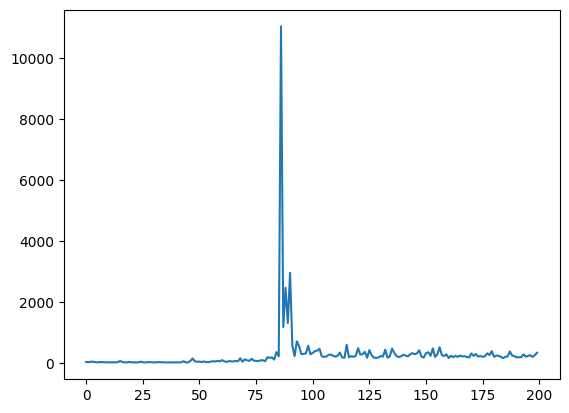

In [43]:
# %load solutions/RL5_exercise6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

cartpole = gym.make("CartPole-v1")

config = {
    "observation_space": cartpole.observation_space.shape[0],
    "nb_actions": cartpole.action_space.n,
    "learning_rate": 0.001,
    "gamma": 0.95,
    "buffer_size": 1000000,
    "epsilon_min": 0.01,
    "epsilon_max": 1.0,
    "epsilon_decay_period": 1000,
    "epsilon_delay_decay": 20,
    "batch_size": 20,
}

agent = DQNAgent(config, DQN)
scores = agent.train(cartpole, 200)
plt.plot(scores)


In [45]:
cartpole = gym.make("CartPole-v1", render_mode="human")

s, _ = cartpole.reset()
for i in range(1000):
    a = greedy_action(DQN, s)
    s, _, d, _, _ = cartpole.step(a)
    if d:
        print("Final nb steps:", i)
        break

cartpole.close()

Final nb steps: 253


# <div id="tricks"></div>Making DQN more efficient

## <div id="optimizer"></div>Changing the optimizer

The question of which optimizer to choose is quite open in RL. Most common choices are RMSprop or Adam (with, sometimes, carefully chosen hyperparameters). For the example of CartPole, it seems Adam with default parameters works better, but that's not a general rule.

## <div id="nb-grad-steps"></div>Several gradient steps

Recall that within an iteration of Value Iteration, one aims at minimizing the $L_n(\theta)$ (before moving on to the next iteration). Why take a single gradient step on this loss when a new sample is collected? Taking several gradient steps can greatly accelerate the convergence in terms of number of collected samples. That's what is commonly called *sample efficiency*.

## <div id="target-networks"></div>Target network

It appears the code above will (probably) slowly converge to $Q^*$ but this convergence might be unstable and noisy. This can be greatly improved by taking several gradient steps on a given loss function $L_n$ instead of changing the loss function after each sample. This idea is similar to the one above. And is the same as that of delayed updates that we introduced in the class on temporal difference learning. 

In practice, this is achieved by the introduction of a *target network* whose parameters are noted $\theta^-$. This idea for DQN was introduced in the **[Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)** paper. At any time step, the loss becomes:
$$L(\theta) = \mathbb{E}_{s,a,r,s'} \left[ \left( r + \gamma \max_{a'} Q(s',a',\theta^-) - Q(s,a;\theta) \right) ^2 \right],$$
and the target network parameters $\theta^-$ are only updated with the Q-network parameters $\theta_n$ every $C$ steps and are held fixed between individual updates.

This process of accumulating several gradient steps into $\theta_n$ before updating $\theta^-$ draws our algorithm closer to a Value Iteration scheme (or a Fitted Q-Iteration scheme for that matter).

Note that more recent approaches smooth out this accumulation process by defining soft updates of the form:
$$\theta^- \leftarrow \beta \theta^- + (1-\beta) \theta_n.$$

## <div id="error-clipping"></div>Error clipping

Another common pratice to stabilize learning is to clip the value of the loss' gradient between $-1$ and $1$. This is not such an uncommon trick, it actually amounts to using an L2 loss for values of the loss between $-1$ and $1$ and an L1 loss outside of this domain. This is also know as the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) or the [smooth L1 loss](https://pytorch.org/docs/stable/nn.html#smoothl1loss).

<div class="alert alert-warning">
    
**Exercise:**  
Modify you code from the previous exercises to include a target network (with $C$ in the order of $100$), a fixed number of gradient steps per acquired sample, and the clipping of the error term. You can also use Adam for improved efficiency.
</div>

In [46]:
# %load solutions/RL5_exercise7.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import numpy as np
import torch
from copy import deepcopy

class DQNAgent:
    def __init__(self, config, model):
        self.gamma = config["gamma"]
        self.batch_size = config["batch_size"]
        self.nb_actions = config["nb_actions"]
        self.memory = ReplayBuffer(config["buffer_size"])
        self.epsilon_max = config["epsilon_max"]
        self.epsilon_min = config["epsilon_min"]
        self.epsilon_stop = config["epsilon_decay_period"]
        self.epsilon_delay = config["epsilon_delay_decay"]
        self.epsilon_step = (self.epsilon_max - self.epsilon_min) / self.epsilon_stop
        self.nb_gradient_steps = config["gradient_steps"]  # NEW NEW NEW
        self.total_steps = 0
        self.model = model
        self.criterion = torch.nn.SmoothL1Loss()  # NEW NEW NEW
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=config["learning_rate"]
        )  # NEW NEW NEW
        self.target_model = deepcopy(self.model).to(device)  # NEW NEW NEW
        self.update_target_freq = config["update_target_freq"]  # NEW NEW NEW

    def gradient_step(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample from memory
        X, A, R, Y, D = self.memory.sample(self.batch_size)

        # Compute y_t = r(s, a) + \gamma * max_a' Q(s', a')
        QYmax = self.target_model(Y).max(1)[0].detach()
        update = torch.addcmul(R, 1 - D, QYmax, value=self.gamma)

        # Compute loss
        QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
        loss = self.criterion(QXA, update.unsqueeze(1))

        # Gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0

        while episode < max_episode:
            # Update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon - self.epsilon_step)

            # Select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = greedy_action(self.model, state)

            # Step and store in memory
            next_state, reward, done, _, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # Train
            for _ in range(self.nb_gradient_steps): # NEW NEW NEW
                self.gradient_step()

            # update target network if needed
            if step % self.update_target_freq == 0: # NEW NEW NEW
                self.target_model.load_state_dict(self.model.state_dict())

            # Next transition
            step += 1
            if done:
                episode += 1
                print(
                    f"Episode {episode:3d}, epsilon {epsilon:6.2f},",
                    f"batch size {len(self.memory):5d},",
                    f"episode return {episode_cum_reward:4.1f}",
                )
                state, _ = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return


<div class="alert alert-warning">
    
**Exercise:**  
Run your code to learn an efficient policy for CartPole. Don't forget to reset the network before you start learning.
</div>

Episode   1, epsilon   1.00, batch size    11, episode return 11.0
Episode   2, epsilon   0.99, batch size    32, episode return 21.0
Episode   3, epsilon   0.96, batch size    61, episode return 29.0
Episode   4, epsilon   0.92, batch size   101, episode return 40.0
Episode   5, epsilon   0.90, batch size   122, episode return 21.0
Episode   6, epsilon   0.88, batch size   142, episode return 20.0
Episode   7, epsilon   0.87, batch size   154, episode return 12.0
Episode   8, epsilon   0.85, batch size   173, episode return 19.0
Episode   9, epsilon   0.79, batch size   237, episode return 64.0
Episode  10, epsilon   0.75, batch size   277, episode return 40.0
Episode  11, epsilon   0.72, batch size   302, episode return 25.0
Episode  12, epsilon   0.71, batch size   316, episode return 14.0
Episode  13, epsilon   0.67, batch size   350, episode return 34.0
Episode  14, epsilon   0.62, batch size   406, episode return 56.0
Episode  15, epsilon   0.56, batch size   464, episode return 

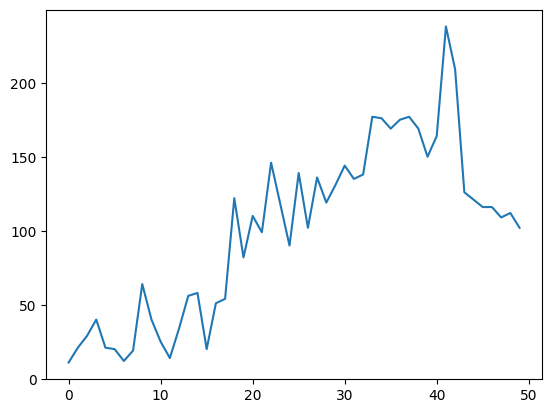

In [47]:
# %load solutions/RL5_exercise8.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

# Let's reset the Q function

import torch
import torch.nn as nn
import gymnasium as gym

cartpole = gym.make("CartPole-v1")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n
nb_neurons = 24

# reset the Q function
DQN = torch.nn.Sequential(
    nn.Linear(state_dim, nb_neurons),
    nn.ReLU(),
    nn.Linear(nb_neurons, nb_neurons),
    nn.ReLU(),
    nn.Linear(nb_neurons, n_action),
).to(device)

config = {
    "observation_space": cartpole.observation_space.shape[0],
    "nb_actions": cartpole.action_space.n,
    "learning_rate": 0.001,
    "gamma": 0.95,
    "buffer_size": 1000000,
    "epsilon_min": 0.01,
    "epsilon_max": 1.0,
    "epsilon_decay_period": 1000,
    "epsilon_delay_decay": 20,
    "batch_size": 20,
    "gradient_steps": 10,
    "update_target_freq": 100,
}

agent = DQNAgent(config, DQN)
scores = agent.train(cartpole, 50)

plt.plot(scores)
torch.save(DQN.state_dict(), "cart_pole_dqn.pth")


In [50]:
cartpole = gym.make("CartPole-v1", render_mode="human")

DQN.load_state_dict(torch.load("cart_pole_dqn.pth"))
s, _ = cartpole.reset()
for i in range(1000):
    a = greedy_action(DQN, s)
    s, _, d, _, _ = cartpole.step(a)
    if d:
        print(i)
        break

cartpole.close()

231


# <div id="metrics"></div>Metrics

Let's take a step back to reflect about what we really measure in the experiment above. We have counted the number of steps per training episode. But during these episodes, the applied policy was $\epsilon$-greedy, not greedy. So this is not an objective measure of performance.

On the other hand, what is really being optimized here is the average sum of discounted rewards.

<div class="alert alert-warning">
    
**Exercise:**  
Enhance your previous code with the monitoring, after each episode, of:
- the number of steps of the training episode
- a Monte Carlo estimate of the total sum of rewards from the (distribution of) starting state,
- a Monte Carlo estimate of the sum of discounted rewards from the (distribution of) starting state,
- an average, over possible starting states $s_0$ of the current $\max_a Q(s_0,a)$.
</div>

In [52]:
# %load solutions/RL5_exercise9.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import numpy as np
import torch
from copy import deepcopy

class DQNAgent:
    def __init__(self, config, model):
        self.gamma = config["gamma"]
        self.batch_size = config["batch_size"]
        self.nb_actions = config["nb_actions"]
        self.memory = ReplayBuffer(config["buffer_size"])
        self.epsilon_max = config["epsilon_max"]
        self.epsilon_min = config["epsilon_min"]
        self.epsilon_stop = config["epsilon_decay_period"]
        self.epsilon_delay = config["epsilon_delay_decay"]
        self.epsilon_step = (self.epsilon_max - self.epsilon_min) / self.epsilon_stop
        self.nb_gradient_steps = config["gradient_steps"]
        self.nb_trials = config["nb_trials"]  # NEW NEW NEW
        self.total_steps = 0
        self.model = model
        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=config["learning_rate"]
        )
        self.target_model = deepcopy(self.model).to(device)
        self.update_target_freq = config["update_target_freq"]

    def MC_eval(self, env, nb_trials):  # NEW NEW NEW
        MC_total_reward = []
        MC_discounted_reward = []
        for _ in range(nb_trials):
            s, _ = env.reset()
            done = False
            total_reward = 0
            discounted_reward = 0
            discount_factor = 1
            while not done:
                a = greedy_action(self.model, s)
                s, r, done, _, _ = env.step(a)
                total_reward += r
                discounted_reward += discount_factor * r
                discount_factor *= self.gamma
            MC_total_reward.append(total_reward)
            MC_discounted_reward.append(discounted_reward)
        return np.mean(MC_discounted_reward), np.mean(MC_total_reward)

    def eval_init_state(self, env, nb_trials):  # NEW NEW NEW
        with torch.no_grad():
            val = []
            for _ in range(nb_trials):
                s, _ = env.reset()
                val.append(
                    self.model(torch.Tensor(s).unsqueeze(0).to(device)).max().item()
                )
        return np.mean(val)

    def gradient_step(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample from memory
        X, A, R, Y, D = self.memory.sample(self.batch_size)

        # Compute y_t = r(s, a) + \gamma * max_a' Q(s', a')
        QYmax = self.target_model(Y).max(1)[0].detach()
        update = torch.addcmul(R, 1 - D, QYmax, value=self.gamma)

        # Compute loss
        QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
        loss = self.criterion(QXA, update.unsqueeze(1))

        # Gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, max_episode):
        # Training monitoring
        episode_return = []
        MC_avg_total_reward = []  # NEW NEW NEW
        MC_avg_discounted_reward = []  # NEW NEW NEW
        avg_Q_init_state = []  # NEW NE W NEW

        # Initialization
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        epsilon = self.epsilon_max
        step = 0

        while episode < max_episode:
            # Update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon - self.epsilon_step)

            # Select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = greedy_action(self.model, state)

            # Step and store in memory
            next_state, reward, done, _, _ = env.step(action)
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += reward

            # Train
            for _ in range(self.nb_gradient_steps):
                self.gradient_step()

            # Update target network if needed
            if step % self.update_target_freq == 0:
                self.target_model.load_state_dict(self.model.state_dict())

            # Next transition
            step += 1
            if done:
                episode += 1

                # Monitoring
                if self.nb_trials > 0:  # NEW NEW NEW
                    MC_dr, MC_tr = self.MC_eval(env, self.nb_trials)
                    Q0 = self.eval_init_state(env, self.nb_trials)
                    MC_avg_total_reward.append(MC_tr)
                    MC_avg_discounted_reward.append(MC_dr)
                    avg_Q_init_state.append(Q0)
                    episode_return.append(episode_cum_reward)
                    print(
                        f"Episode {episode:2d}, epsilon {epsilon:6.2f},",
                        f"batch size {len(self.memory):4d}, ep return {episode_cum_reward:4.1f},",
                        f"MC tot {MC_tr:6.2f}, MC disc {MC_dr:6.2f}, Q0 {Q0:6.2f}",
                    )
                else:
                    episode_return.append(episode_cum_reward)
                    print(
                        f"Episode {episode:3d}, epsilon {epsilon:6.2f},",
                        f"batch size {len(self.memory):5d},",
                        f"episode return {episode_cum_reward:4.1f}",
                    )

                # Start new episode
                state, _ = env.reset()
                episode_cum_reward = 0
            else:
                state = next_state

        return (
            episode_return,
            MC_avg_discounted_reward,
            MC_avg_total_reward,
            avg_Q_init_state,
        )


<div class="alert alert-warning">
    
**Exercise:**  
Use this monitoring to plot these values versus the number of episodes, after training.
</div>

Episode  1, epsilon   1.00, batch size   11, ep return 11.0, MC tot  32.76, MC disc  16.03, Q0  -0.17
Episode  2, epsilon   0.99, batch size   35, ep return 24.0, MC tot   9.46, MC disc   7.67, Q0   0.70
Episode  3, epsilon   0.97, batch size   50, ep return 15.0, MC tot   9.42, MC disc   7.65, Q0   0.80
Episode  4, epsilon   0.94, batch size   78, ep return 28.0, MC tot  10.88, MC disc   8.51, Q0   0.83
Episode  5, epsilon   0.93, batch size   96, ep return 18.0, MC tot  13.18, MC disc   9.73, Q0   0.83
Episode  6, epsilon   0.90, batch size  118, ep return 22.0, MC tot  10.64, MC disc   8.39, Q0   1.79
Episode  7, epsilon   0.89, batch size  130, ep return 12.0, MC tot  10.64, MC disc   8.34, Q0   1.82
Episode  8, epsilon   0.87, batch size  151, ep return 21.0, MC tot  12.82, MC disc   9.61, Q0   1.80
Episode  9, epsilon   0.86, batch size  162, ep return 11.0, MC tot  14.02, MC disc  10.22, Q0   1.79
Episode 10, epsilon   0.85, batch size  175, ep return 13.0, MC tot  12.72, MC dis

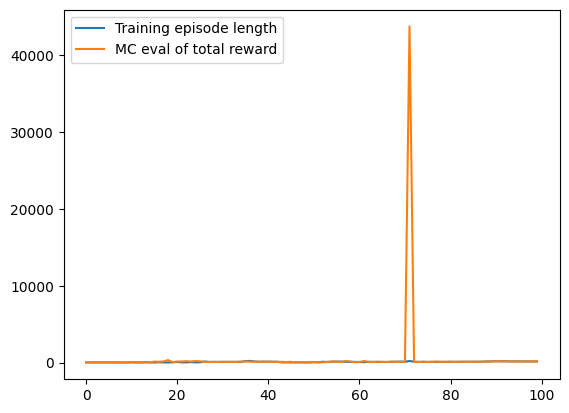

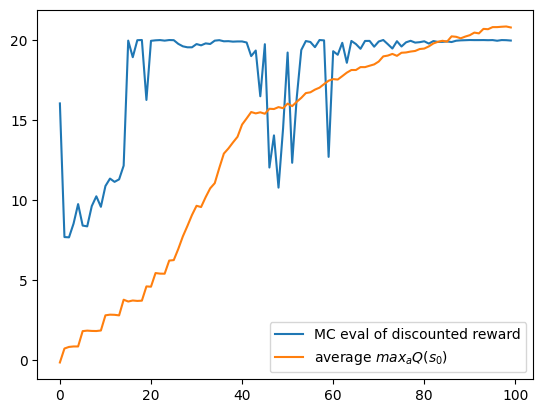

In [55]:
# %load solutions/RL5_exercise10.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

# Let's reset the Q function

import torch
import torch.nn as nn
import gymnasium as gym

cartpole = gym.make("CartPole-v1")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = cartpole.observation_space.shape[0]
n_action = cartpole.action_space.n
nb_neurons = 24

# reset the Q function
DQN = torch.nn.Sequential(
    nn.Linear(state_dim, nb_neurons),
    nn.ReLU(),
    nn.Linear(nb_neurons, nb_neurons),
    nn.ReLU(),
    nn.Linear(nb_neurons, n_action),
).to(device)

config = {
    "observation_space": cartpole.observation_space.shape[0],
    "nb_actions": cartpole.action_space.n,
    "learning_rate": 0.001,
    "gamma": 0.95,
    "buffer_size": 1000000,
    "epsilon_min": 0.01,
    "epsilon_max": 1.0,
    "epsilon_decay_period": 1000,
    "epsilon_delay_decay": 20,
    "batch_size": 20,
    "gradient_steps": 10,
    "update_target_freq": 100,
    "nb_trials": 50,
}

agent = DQNAgent(config, DQN)
ep_length, disc_rewards, tot_rewards, Q0 = agent.train(cartpole, 100)

plt.plot(ep_length, label="Training episode length")
plt.plot(tot_rewards, label="MC eval of total reward")
plt.legend()
plt.figure()
plt.plot(disc_rewards, label="MC eval of discounted reward")
plt.plot(Q0, label="average $max_a Q(s_0)$")
plt.legend()


Remarks on CartPole:
- Have you noted that Q overestimates the true value of the optimal policy? More on this in [this paper](https://papers.nips.cc/paper/3964-double-q-learning) if you are interested.
- Have you noted that the greedy policy is optimal much sooner than the $Q$ function?
- Have you remarked that the greedy policy performs well much sooner than the agent's policy (which is $\epsilon$-greedy)?
- Can you anticipate the importance of well tuned exploration, for instance if the state space is much larger, or if parts of it are very hard to reach?
- Can you anticipate the effect of taking a larger $\gamma$?

<div class="alert alert-warning">
    
**Exercise:**  
Train on SwingUp.
</div>

In [57]:
# %load solutions/RL5_exercise11.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

# Let's reset the Q function

import torch
import torch.nn as nn
from environments.swingup import CartPoleSwingUp

swingup = CartPoleSwingUp()

config = {
    "observation_space": swingup.observation_space.shape[0],
    "nb_actions": swingup.action_space.n,
    "learning_rate": 0.001,
    "gamma": 0.95,
    "buffer_size": 1000000,
    "epsilon_min": 0.01,
    "epsilon_max": 1.0,
    "epsilon_stop": 10000,
    "epsilon_decay_period": 1000,
    "epsilon_delay_decay": 100,
    "batch_size": 20,
    "gradient_steps": 10,
    "update_target_freq": 100,
    "nb_trials": 0,
}

DQN = torch.nn.Sequential(
    nn.Linear(swingup.observation_space.shape[0], 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, swingup.action_space.n),
).to(device)

agent = DQNAgent(config, DQN)
ep_length, disc_rewards, tot_rewards, Q0 = agent.train(swingup, 30)
torch.save(DQN.state_dict(), "swingup_dqn.pth")


Episode   1, epsilon   0.93, batch size   175, episode return -10.0
Episode   2, epsilon   0.78, batch size   324, episode return -10.0
Episode   3, epsilon   0.59, batch size   519, episode return -10.0
Episode   4, epsilon   0.32, batch size   783, episode return -10.0
Episode   5, epsilon   0.18, batch size   934, episode return -10.0
Episode   6, epsilon   0.03, batch size  1077, episode return -10.0
Episode   7, epsilon   0.01, batch size  1133, episode return -10.0
Episode   8, epsilon   0.01, batch size  1203, episode return -10.0
Episode   9, epsilon   0.01, batch size  1255, episode return -10.0
Episode  10, epsilon   0.01, batch size  1317, episode return -10.0
Episode  11, epsilon   0.01, batch size  1369, episode return -10.0
Episode  12, epsilon   0.01, batch size  1433, episode return -10.0
Episode  13, epsilon   0.01, batch size  1606, episode return -10.0
Episode  14, epsilon   0.01, batch size  1648, episode return -10.0
Episode  15, epsilon   0.01, batch size  1707, e

In [64]:
DQN.load_state_dict(torch.load("swingup_dqn.pth"))

swingup = CartPoleSwingUp(render_mode="human")
s, _ = swingup.reset()
tot_rew = 0
for _ in range(1000):
    a = greedy_action(DQN, s)
    s, r, d, _, _ = swingup.step(a)
    tot_rew += r
    if d:
        break

print(f"Total nb steps: {i}, total reward: {tot_rew}")

swingup.close()

Total nb steps: 231, total reward: -10.0


Remarks on SwingUp:
- Did your DQN learn to avoid the -10 penalty instead of swinging up? The exploration question becomes a crucial issue, doesn't it?

# <div id="dqn-image"></div>DQN on image-based tasks

Now it's time to turn towards Pong. As you noted earlier, the frame information in Pong is not sufficient to define an MDP, but stacking several frames together allows to recover the Markov property.

We could wish to modify the previous replay buffer so that frames are stored only once (for memory efficiency). Then this new replay buffer would still need to return stacks of 4 frames when `sample()` is called.

Fortunately, there's a simpler way to do that.
We can use a wrapper (provided by Gym in this case) so that calling env.step(a) returns a stack of 4 frames.
This wrapper actually only stores each frame once which optimizes memory efficiency. This way, we can keep on using our previous replay buffer class.

In [ ]:
from gymnasium.wrappers import FrameStackObservation
pong = FrameStackObservation(pong, 4)

In [ ]:
s, _ = pong.reset()
print(torch.Tensor(s).shape)

The two DQN papers ([Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602) and [Human-level control through deep reinforcement learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)) actually introduce two different neural network architectures.

The 2013 paper uses this architecture:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 2 linear units (one for each action's value)

The 2015 paper 
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 32 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 64 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Convolutions with 64 filters of size $3\times 3$ and stride 1. The activation is a ReLU function.
- layer 4: Fully connected with 512 ReLU units
- layer 5 (output): Fully connected with 2 linear units (one for each action's value)

Also, it is a good practice to pre-fill the replay buffer with randomly sampled experience. The 2015 paper runs a random policy for 50000 steps to feed the replay buffer before training.

<div class="alert alert-warning">
    
**Exercise:** Create the corresponding neural network and adapt your optimization code from the previous exercice to train on Pong (you can take $C$ much larger, in the order of $10000$).
</div>

Caveat: unless you have a good GPU and a fair amount of time ahead of you (several hours or more), it is recommended to run this computation for a limited number of episodes, on a cloud computing service (or on a dediated machine).

In [ ]:
# %load solutions/RL5_exercise12.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

To give you an idea of the behavior of a trained agent, you can check the following videos.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("p88R2_3yWPA")

In [ ]:
YouTubeVideo("TmPfTpjtdgg")

# <div id="further"></div>Going further

A lot of contributions have built on the initial success of DQN. Among those, some are combined and discussed in the **[Rainbow: Combining Improvements in Deep Reinforcement Learning](https://arxiv.org/abs/1710.02298)** paper. We will simply summarize their key ideas here, by decreasing order of importance (according to the paper).

- N-step returns. Use samples that accumulate several returns rather than the 1-step return of TD(0).
- [Prioritized experience replay](https://arxiv.org/abs/1511.05952). Inspired by the model-based [Prioritized Sweeping](https://link.springer.com/article/10.1007/BF00993104) approach, bias the distribution used to sample mini-batches in order to present high residual samples to the optimizer. Prioritized Sweeping is designed to accelerate the convergence in $L_\infty$ norm for tabular representations.
- [Distributional value functions](https://arxiv.org/abs/1707.06887). Instead of estimating $\mathbb{E}(\sum_t \gamma^t r_t)$, estimate the distribution of $\sum_t \gamma^r r_t$ and iterate on it.
- [NoisyNet](https://arxiv.org/abs/1706.10295). Instead of an $\epsilon$-greedy exploration strategy, introduce noise in the network's parameters to drive the exploration.
- [Dueling architecture](https://arxiv.org/abs/1511.06581). The neural network's architecture splits $Q$ into the estimation of a value $V(s)$ and an advantage $A(s,a)$ with shared first layers.
- [Double Q-learning](https://arxiv.org/abs/1509.06461). Q-learning is prone to over-estimation of the true optimal Q function (especially in high variance environments). Double Q-learning aims at compensating this weakness by introducing an under-estimation mechanism based on a second Q function.

Beyond these improvements, new work is published each year that leads to a better understanding of the interplay between Deep Learning and RL.

# <div id="challenge"></div>Challenge

In this challenge, we provide two new environments, on top of the SwingUp problem introduced before. All environments feature different difficulties. It is recommended that you focus on a single environment.

## <div id="bicycle"></div>Bicycle

This environment was originally introduced in the 1998 article on **[Learning to Drive a Bicycle Using Reinforcement Learning and Shaping](#https://www.researchgate.net/publication/221346431_Learning_to_Drive_a_Bicycle_Using_Reinforcement_Learning_and_Shaping)** by J. Randløv and P. Alstrøm. Notably, it was also one of the key benchmarks for **[Least Squares Policy Iteration](http://www.jmlr.org/papers/volume4/lagoudakis03a/lagoudakis03a.pdf)** by Lagoudakis and Parr in 2003.

The environment provided here uses the exact same simulator but defines more rigorously the state variables. It is not a gym environment and has no `render` method, but it still provides the `step` and `reset` methods.

In short, in this environment you try to ride a bicyle from an initial location $(x,y)=(0,0)$ to a goal that is located one kilometer further $(x_{goal},y_{goal})=(1000,0)$.

The bicycle state variables are:
- $\theta$ the angle of the handlebar
- $\dot{\theta}$
- $\omega$ the tilt angle between the $z$-axis and the bicycle+cyclist center of mass
- $\dot{\omega}$
- $x_b,y_b$ the position of the bicyle's back tire
- $x_f,y_f$ the position of the bicyle's front tire
- $\psi'_{goal}$ a not-so-useful variable kept for historical reasons, that is roughly proprotional to $\psi_{goal}$
- $d_{goal}$ the distance between the front tire and the goal
- $\psi$ the bicycle's heading angle (angle between the bicycle and the y-axis)
- $\psi_{goal}$ the angle between the bicycle back wheel - front wheel axis, and the back wheel - goal axis

The agent starts at $(x_b,y_b)=(0,0)$ with a random heading in $[-\pi,\pi]$, and random small values for $\theta$, $\dot{\theta}$, $\omega$ and $\dot{\omega}$ around the unstable equilibrium point.

In [ ]:
from environments.bicycle import Bicycle
bike = Bicycle()
s, _ = bike.reset()
print(s)

The cyclist moves at a constant speed and his actions to control the bicycle consist in applying a torque to the handlebar or shifting his weight left or right. The action space is discrete and consists of 5 actions. What you pass to the `step` method is the action index.

The episode ends when the tilt angle exceeds $\frac{\pi}{15}$.

To encourage the bike staying up and guiding it towards the goal, the reward model uses *reward shaping*. It is written:
$$r(s,a,s') = \omega^2 - \omega'^2 + k\cdot\left( d_{goal} - d'_{goal} \right)$$

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

print(bike.action_set)
S = []
s, _ = bike.reset()
S.append(s)
for i in range(1000):
    s, r, d, _, _ = bike.step(0)
    S.append(s)
    if d:
        break

print("trajectory length", len(S))
S = np.array(S)
plt.plot(S[:, 4], S[:, 5]);

## <div id="sti"></div>Structured Treatment Interruptions

This environment implements the simulator defined in **[Dynamic Multidrug Therapies for HIV: Optimal and STI Control Approaches](https://www.aimspress.com/fileOther/PDF/MBE/1551-0018_2004_2_223.pdf)** by B. M. Adams et al. (2004). It was notably used in **[Clinical data based optimal STI strategies for HIV: a reinforcement learning approach](https://ieeexplore.ieee.org/document/4177178)** by D. Ernst et al. (2006).

This environment simulates the immune system of an HIV-infected patient. It is not a gym environment and has no `render` method, but it still provides the `step` and `reset` methods. 

In short, HIV can infect two types of cells (type 1 and type 2 below) and replicate itself, which increases the virus load in the blood stream. The immune system fights off the virus by increasing the concentration of macrophages (effector cells below).

The patient state variables are:
- $T_1$ healthy type 1 cells concentration (cells per mL)
- $T_1^*$ infected type 1 cells concentration (cells per mL)
- $T_2$ healthy type 2 cells concentration (cells per mL)
- $T_2^*$ infected type 2 cells concentration (cells per mL)
- $V$ free virus (copies per mL)
- $E$ immune effector cells concentration (cells per mL)

Once infected, if no treatment is applied, the patient naturally evolve to one of two steady states: either the immune system controls the infection and the patient is healthy, or the infection dominates and the patient is unhealthy.

By default `reset` deterministically puts the patient in the infected unhealthy state.

    The transition() function allows to simulate continuous time dynamics and control.
    The step() function is tailored for the evaluation of Structured Treatment Interruptions.

In [ ]:
from environments.hiv_patient import HIVPatient
patient = HIVPatient()
print("Uninfected patient:", patient.reset("uninfected")[0])
print("Unhealthy patient:", patient.reset()[0]) # actually equivalent to patient.reset("unhealthy")
print("Healthy patient:", patient.reset(mode="healthy")[0])

The `step` method simulates the evolution of the patient over a time step of $5$ days. The system is deterministic. For example, if we want to simulate a patient with a 25% immunity loss, with no treatment, over 400 days, we could do:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from environments.hiv_patient import HIVPatient

patient = HIVPatient()
s, _ = patient.reset(mode="healthy")
s[5] *= .75
patient.E *= .75
print(patient.E)
dur = 80 # 400/5
#nb_steps = int(dur//1e-3)
states = [s]
for _ in range(dur):
    s, r, d, _, _ = patient.step(0)
    states.append(s)
    
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
npst = np.array(states)
axs[0,0].plot(npst[:,0])
axs[0,0].set_title("T1")
axs[0,1].plot(npst[:,1])
axs[0,1].set_title("T1*")
axs[0,2].plot(npst[:,2])
axs[0,2].set_title("T2")
axs[1,0].plot(npst[:,3])
axs[1,0].set_title("T2*")
axs[1,1].plot(npst[:,4])
axs[1,1].set_title("V")
axs[1,2].plot(npst[:,5])
axs[1,2].set_title("E");

Two types of drugs can be given to the patient, that differ in the way they affect the viral load. The problem we look at consists in giving or not a certain drug at every step, to allow for **structured treatment interruptions** (STI). Such interruptions have double goal: train the immune system to react by itself and provide the patient with a better quality of life.

The action space is discrete and consists of 5 actions. What you pass to the `step` method is the action index.

The patient's death over the course of treatment is not explicitly modelled (but the viral load can reach very high values). So this simulator does not have a termination condition (`step` never returns `done=True`). The reward model discourages giving drugs, aims at a low viral load and a high immunity:
$$r(s,a,s') = -k_V \cdot V + k_E \cdot E -k_1 R_2 - k_2 \cdot R_2$$
where $R_1$ and $R_2$ are the amounts of prescribed drugs 1 and 2 respectively.

In [ ]:
print(patient.action_set)

## <div id="turn"></div>Your turn to play

<div class="alert alert-warning">
    
**Exercise (open-ended):**  
Your turn to play!  
Can you solve SwingUp? Bicycle? STI?  
Why are these problems more difficult than CartPole?  
Be creative!
</div>